# QCNN tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import os

from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

colors = [
    "#7eb0d5",
    "#fd7f6f",
    "#b2e061",
    "#bd7ebe",
    "#ffb55a",
    "#8bd3c7"
]

In [2]:
import torch
from torch import distributions
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

import torchvision


class QuantumConv2d(nn.Conv2d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 eps,
                 cap,
                 ratio,
                 delta,
                 stride=1,
                 padding=0,
                 dilation=1):
        """Base class for quantum convolutional layer.
        
        Args:
            in_channels (int): number of input channels.
            out_channels (int): number of output channels.
            kernel_size (int): size of the convolution kernel.
            eps (float): precision of quantum multiplication.
            cap (float): value for cap 'relu' activation function.
            ratio (float): precision of quantum tomography.
            delta (float): precision of quantum gradient estimation.
            stride (int, optional): convolution stride. Defaults to 1.
            padding (int, optional): convolution padding. Defaults to 0.
            dilation (int, optional): convolution dilation. Defaults to 1.
        """
        # convolution layer
        super(QuantumConv2d, self).__init__(in_channels,
                                            out_channels,
                                            kernel_size,
                                            stride=stride,
                                            padding=padding,
                                            dilation=dilation,
                                            groups=1,
                                            bias=False,
                                            padding_mode='zeros')

        # set/check quantum parameters
        self.set_quantum_params(eps, cap, ratio, delta)

        # unfold operation
        self.unfold = nn.Unfold(kernel_size, dilation, padding, stride)

        # gradient operation
        self.weight.register_hook(self.simulate_quantum_gradient)

    def forward(self, input):

        # get convolutional layer output
        output = super(QuantumConv2d, self).forward(input)
        output = torch.clamp(output, 0., self.cap)

        # get quantum output
        quantum_output = self.simulate_quantum_output(input, output)

        # update convolutional layer output
        output.data = quantum_output.data

        return output

    def simulate_quantum_output(self, input, output):
        with torch.no_grad():
            if self.eps > 0.:
                # get kernel norm
                kernel_matrix = self.weight.data.flatten(start_dim=1)
                kernel_matrix = kernel_matrix.transpose(0, 1)
                kernel_norm = torch.norm(kernel_matrix, dim=0)
                kernel_norm = kernel_norm.repeat(input.size(0), 1, 1)

                # get input norm
                input_matrix = self.unfold(input)
                input_matrix = input_matrix.transpose(1, 2)
                input_norm = torch.norm(input_matrix, dim=2)
                input_norm = input_norm.unsqueeze(2)

                # add gaussian noise
                product_norm = torch.bmm(input_norm, kernel_norm)
                product_norm = product_norm.reshape(output.shape)
                noise = torch.randn(output.shape, device=output.device)
                output += 2 * self.eps * product_norm * noise
                output = torch.clamp(output, 0., self.cap)

            if self.ratio < 1.:
                # quantum sampling
                num_samples = int(self.ratio * output.shape[1:].numel())
                probs = output.flatten(start_dim=1)
                distribution = distributions.Categorical(probs=probs)
                samples = distribution.sample((num_samples, )).flatten()
                idxs = torch.arange(0, input.size(0))
                idxs = idxs.repeat(1, num_samples).flatten()
                mask = torch.zeros_like(probs)
                mask[idxs, samples] = 1.
                mask = mask.reshape(output.shape)
                output = mask * output
        return output

    def simulate_quantum_gradient(self, grad):
        if self.delta > 0.:
            # add quantum gradient estimation error to the kernel
            noise = torch.randn(grad.shape, device=grad.device)
            grad_norm = torch.norm(grad)
            error = self.delta * grad_norm * noise
            grad += error
        return grad

    def set_quantum_params(self, eps=None, cap=None, ratio=None, delta=None):
        if eps is not None:
            assert 0. <= eps <= 1., 'epsilon should verify: 0.<=eps<=1.'
            self.eps = eps
        if cap is not None:
            assert 0. < cap, 'cap should verify: 0.<cap'
            self.cap = cap
        if ratio is not None:
            assert 0. < ratio <= 1., 'ratio should verify: 0.<ratio<=1.'
            self.ratio = ratio
        if delta is not None:
            assert 0 <= delta <= 1., 'delta should verify: 0.<=delta<=1.'
            self.delta = delta

    def convert_to_classical(self):
        layer = nn.Conv2d(self.in_channels,
                          self.out_channels,
                          self.kernel_size,
                          self.stride,
                          self.padding,
                          self.dilation,
                          groups=1,
                          bias=False,
                          padding_mode='zeros')
        layer.weight.data = self.weight.data
        return layer

    def extra_repr(self):
        s = '{in_channels}, {out_channels}, kernel_size={kernel_size}, '
        s += 'quantum_eps={eps}, quantum_cap = {cap}, '
        s += 'quantum_ratio={ratio}, quantum_delta = {delta}, '
        s += 'stride={stride}'
        if self.padding != (0, ) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1, ) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

In [3]:
class QCNN(nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        self.conv1 = nn.Sequential(         
            QuantumConv2d(
                in_channels  = 1,              
                out_channels = 32,            
                kernel_size  = 3,              
                stride       = 1,                   
                padding      = 0,  
                eps          = 0.01,
                cap          = 10,
                ratio        = 0.5,
                delta        = 0.01                
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels  = 32,              
                out_channels = 64,            
                kernel_size  = 3,              
                stride       = 1,                   
                padding      = 0,                  
            ),   
            nn.ReLU(),                                      
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels  = 64,              
                out_channels = 64,            
                kernel_size  = 3,              
                stride       = 1,                   
                padding      = 0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # fully connected layer, output 10 classes
        self.dense = nn.Linear(64 * 4 * 4, 100)
        self.out = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv3 to (batch_size, n_neurons)
        x = x.view(x.size(0), -1) 
        x = self.dense(x)      
        output = self.out(x)
        return output, x    # return x for visualization
    

In [4]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),  
    download = True           
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [6]:
print(train_data)
print()
print(test_data)
print()
print()
print("training data shape:\t", train_data.data.shape)
print("test data shape:\t", test_data.data.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


training data shape:	 torch.Size([60000, 28, 28])
test data shape:	 torch.Size([10000, 28, 28])


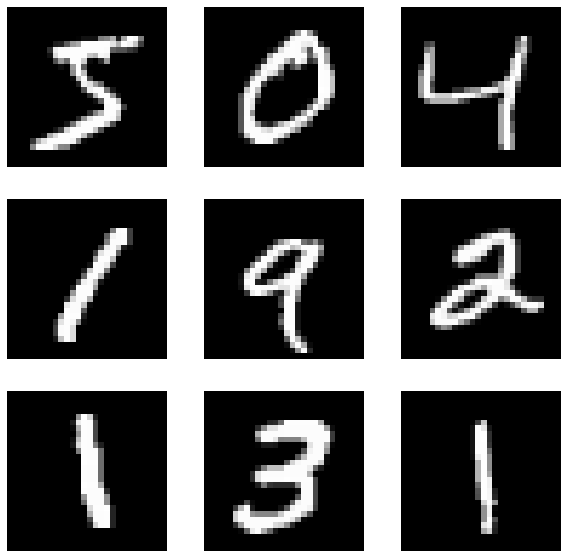

In [7]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    ax = fig.add_subplot(330 + 1 + i)
    ax.axis("off")
    ax.imshow(train_data.data[i], cmap="gray")
    
plt.show()

In [8]:
BATCH_SIZE = 30
loaders = {
    'train' : torch.utils.data.DataLoader(
        train_data, 
        batch_size  = BATCH_SIZE, 
        shuffle     = True, 
        num_workers = 1
    ),
    'test'  : torch.utils.data.DataLoader(
        test_data, 
        batch_size  = BATCH_SIZE, 
        shuffle     = True, 
        num_workers = 1
    ),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x29219d6d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x29219d850>}

Feature batch shape: torch.Size([30, 1, 28, 28])
Labels batch shape: torch.Size([30])


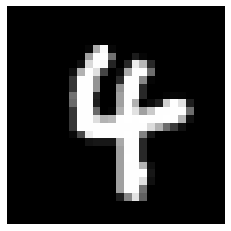

Label: 4


In [9]:
# use DataLoader to randomly pick batches of data
train_features, train_labels = next(iter(loaders["train"]))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()
print(f"Label: {label}")

In [10]:
# function that computes the output shape of a convolutional or pooling layer
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (h,w) and returns a tuple of (h,w)
    """
    
    if type(h_w) is not tuple:
        h_w = (h_w, h_w)
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    if type(stride) is not tuple:
        stride = (stride, stride)
    
    if type(pad) is not tuple:
        pad = (pad, pad)
    
    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1)// stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1)// stride[1] + 1
    
    return h, w

In [11]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [12]:
model = QCNN()

loss_fn   = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr = 0.01)   


def train_one_epoch(epoch_index, tb_writer, n_batches, verbose=False, save=False):
    running_loss  = 0.
    last_loss     = 0.
    total_correct = 0.

    log_batches = int(n_batches / 10)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(loaders["train"]):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs, _ = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        total_correct += get_num_correct(outputs, labels)

        # Gather data and report
        running_loss += loss.item()
        if i % log_batches == log_batches-1:
            last_loss = running_loss / log_batches # average loss per batch (averaged over log_batches batches)
            avg_acc   = total_correct / (len(inputs) * i)
            if verbose: print(f'  batch {i + 1} loss: {last_loss}')
            if save:
                tb_x = epoch_index * len(loaders["train"]) + i + 1
                tb_writer.add_scalar('batch_loss', last_loss, tb_x)
                tb_writer.add_scalar('batch_accuracy', avg_acc, tb_x)
            running_loss = 0.

    return last_loss, total_correct

In [13]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer    = SummaryWriter(log_dir=f'torch_logs/{timestamp}')
train_writer    = SummaryWriter(log_dir=f'torch_logs/{timestamp}/train')
valid_writer    = SummaryWriter(log_dir=f'torch_logs/{timestamp}/validation')

EPOCHS    = 10
n_batches = len(loaders["train"])

images, labels = next(iter(loaders["train"]))
grid = torchvision.utils.make_grid(images)
writer.add_image("images", grid)
writer.add_graph(model, images)
writer.close()

In [14]:
best_vloss = 1_000_000.
save_model = False
save_loss  = True
verbose    = False

for epoch_number, _ in enumerate(range(EPOCHS)):
    print(f'starting EPOCH {epoch_number + 1}')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, total_correct = train_one_epoch(epoch_number, train_writer, n_batches, verbose=verbose, save=save_loss)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    total_vcorrect = 0.
    for i, vdata in enumerate(loaders["test"]):
        vinputs, vlabels = vdata
        voutputs, _      = model(vinputs)
        vloss            = loss_fn(voutputs, vlabels)
        running_vloss   += vloss
        total_vcorrect += get_num_correct(voutputs, vlabels)

    avg_vloss = running_vloss / (i + 1)
    if verbose: print(f'LOSS train {avg_loss} valid {avg_vloss}')

    # Log the running loss averaged per batch
    # for both training and validation
    
    train_writer.add_scalar("epoch_loss",     avg_loss, epoch_number)
    train_writer.add_scalar("epoch_accuracy", total_correct  / len(train_data), epoch_number)
    valid_writer.add_scalar("epoch_loss",     avg_vloss, epoch_number)
    valid_writer.add_scalar("epoch_accuracy", total_vcorrect / len(test_data), epoch_number)

    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

print(f'LOSS train {avg_loss} valid {avg_vloss}')
print(f'ACCURACY train {total_correct / len(train_data)} valid {total_vcorrect / len(test_data)}')

if save_model:
    model_path = f'models/lai_torch_model_{timestamp}' 
    torch.save(model.state_dict(), model_path)

starting EPOCH 1
starting EPOCH 2
starting EPOCH 3
starting EPOCH 4
starting EPOCH 5
starting EPOCH 6
starting EPOCH 7
starting EPOCH 8
starting EPOCH 9
starting EPOCH 10
LOSS train 0.1689699151692912 valid 0.11693553626537323
ACCURACY train 0.95465 valid 0.9652
